# Homework 04 - Applied ML

## Question 1: Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.


#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to brush up your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import linear_model
import networkx as nx
from IPython.display import display, HTML
%matplotlib inline

In [2]:
dataset = pd.read_csv('lalonde.csv')
dataset.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


#### 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?

## Answer
We divide the dataset into two groups: treated and non-treated (according to the indicator variable *treat*), and we try to evaluate whether there are differences in earning on the outcome variable (*re78*).

In this step:
- We compare the two groups and features associated with them (both with graphs and aggregate statistics).
- We analyse the raw data by observing the mean and the median of the earnings, as well as the size of the dataset.
- We try to gain more insight into the data.

In [3]:
# Display non-zero count for each earning feature
print('Amount of 0-salaries')
(dataset[['re74', 're75', 're78']] == 0).describe().loc[['count', 'freq']]

Amount of 0-salaries


,re74,re75,re78
count,614,614,614
freq,371,369,471


As we can see in the table above, it appears that many earnings are 0. The value 0 means that the person was unemployed in that year. For instance, in 1978 (`re78`) only 471 out of 614 people were employed.

For this reason, in our following analysis, we decided to split these features into two parts, and analyze them separately:
- Employment flag: **true** if the person was employed in the year in question ('74, '75 or '78).
- Actual earning: we plot the earning histogram/distribution only for non-zero values (that is, for people that were employed in the year in question).

This allows us to interpret the data more clearly.

In [4]:
dataset['employed74'] = dataset['re74'] > 0
dataset['employed75'] = dataset['re75'] > 0
dataset['employed78'] = dataset['re78'] > 0
dataset.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,employed74,employed75,employed78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,False,False,True
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,False,False,True
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,False,False,True
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,False,False,True
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,False,False,True


We now proceed with the actual analysis.

In [5]:
# We define this helper function for analyzing the outcome variable. It will come handy throughout the rest of the homework.
def analyse_earnings_distribution(dataset):
    """ Split the data and analyse the earnings:
    -Compute and plot the distributions.
    -Compute the descriptive statistics to summarize the earnings.
    """
    outcome_treated = dataset[dataset['treat'] == 1]['re78']
    outcome_nontreated = dataset[dataset['treat'] == 0]['re78']
    
    outcome_treated_employed = outcome_treated[outcome_treated > 0]
    outcome_nontreated_employed = outcome_nontreated[outcome_nontreated > 0]
    
    # Display counts (for the entire population)
    description = pd.DataFrame()
    description['Treated'] = outcome_treated.describe().loc[['count']].astype(int)
    description['Non-treated'] = outcome_nontreated.describe().loc[['count']].astype(int)
    display(description)
    
    # Plot normalized histogram (i.e. density) along with fitting line
    bins = np.linspace(dataset['re78'].min(), dataset['re78'].max(), 30)
    colors = sns.color_palette()
    sns.distplot(outcome_treated_employed, kde=False, fit=stats.expon, bins=bins, color=colors[0], fit_kws={'color': colors[0]})
    ax = sns.distplot(outcome_nontreated_employed, kde=False, fit=stats.expon, bins=bins, color=colors[1], fit_kws={'color': colors[1]})
    ax.set_xlim(0,)
    plt.grid()
    plt.legend(['Treated', 'Non-treated'])
    plt.title('Distribution of earnings (employed people)')
    plt.xlabel('Earnings ($)')
    plt.ylabel('Density')
    plt.show()

    # Display aggregate statistics for employed people
    description = pd.DataFrame()
    description['Earnings (treated)'] = outcome_treated_employed.describe()
    description['Earnings (non-treated)'] = outcome_nontreated_employed.describe()
    
    description['Earnings (treated)'] = description['Earnings (treated)'].astype("int")
    description['Earnings (non-treated)'] = description['Earnings (non-treated)'].astype("int")
    display(HTML('<h3>Statistics of employed people</h3>'))
    display(description)
    
    # Display aggregate statistics for unemployed people
    display(HTML('<h3>Employment rates:</h3>'))
    count_all = dataset.groupby(['treat'])['employed78'].count()
    fractions = dataset.groupby(['treat'])['employed78'].sum()/count_all
    display(HTML('<b>Treated group:</b> ' + '{0:.2f}'.format(fractions[0]) + '%'))
    display(HTML('<b>Non-treated group:</b> ' + '{0:.2f}'.format(fractions[1]) + '%'))

,Treated,Non-treated
count,185,429


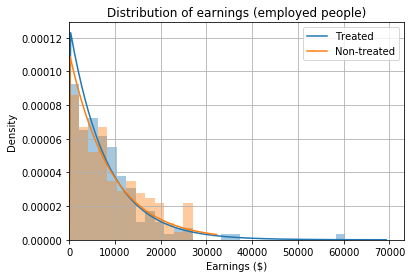

,Earnings (treated),Earnings (non-treated)
count,140,331
mean,8389,9051
std,8042,7087
min,289,31
25%,3167,2978
50%,6504,7310
75%,11017,14131
max,60307,25564


In [6]:
analyse_earnings_distribution(dataset)

**Observations:**
- It appears that the two distributions are heavy-tailed (i.e they resemble a power law), and they do not seem to differ significantly. Since we are dealing with a heavy-tailed distribution, computing the mean does not make much sense since it is heavily affected by the few high values. Therefore, it is better to consider the more robust median to compare the earnings.
- By inspecting the median, it seems that the non-treated group has slightly higher earnings than the treated group. However, we have to argue whether this difference is significant. In addition, we can see that the population sizes are unbalanced: we have more individuals in the non-treatment group (429) than the treatment group (185).

**Conclusion:**
Our naive analysis would lead us to the conclusion that there is not sufficient evidence for the treatment being effective in improving the income. However, as such, our argument is still weak. In the next part of the homework we will try to gain more evidence by doing a more in-depth analysis.

#### 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

## Answer
Before drawing any conclusion we have to assess whether the assignment of participants to the treatment is random, i.e. ideally it should not be possible to determine if an individual has been assigned to the treatment by just looking at their features.

For this purpose we will first plot the distribution of all the feature of the individuals after dividing them into treated and non-treated groups.

In [7]:
def plot_features(dataset):
    n_cols, n_rows = 2, 5
    width, heigth = n_cols*5, n_rows*5
    
    fig, axs = plt.subplots(n_rows, n_cols)
    fig.set_size_inches(width, heigth)
    
    treated = dataset[dataset['treat'] == 1]
    nontreated = dataset[dataset['treat'] == 0]
    
    # Plot continuous features (along with their fitted density curve, using Kernel Density Estimation)
    continuous = ['age', 'educ', 're74', 're75']
    for i, feature in enumerate(continuous):
        r, c = int(i/2), i%2
        bins = np.linspace(dataset[feature].min(), dataset[feature].max(), 20)
        sns.distplot(treated[feature][treated[feature] > 0], bins=bins, ax=axs[r][c])
        sns.distplot(nontreated[feature][nontreated[feature] > 0], bins=bins, ax=axs[r][c])
        axs[r][c].legend(['Treated', 'Non-treated'])
        axs[r][c].set_ylabel('Density')
        axs[r][c].set_xlim(0,)

    # Plot categorical features
    discretes = ['black', 'hispan', 'married', 'nodegree', 'employed74', 'employed75']
    contrary = {'black': 'not black', 'hispan': 'not hispan', 'married': 'unmarried', 'nodegree': 'with degree',
               'employed74': 'unemployed74', 'employed75': 'unemployed75'}
    for i, feature in enumerate(discretes):
        r, c = int(i/2)+2, i%2
        count_all = dataset.groupby(['treat'])[feature].count()
        (dataset.groupby(['treat', feature])[feature].count()/count_all).unstack()\
            .plot.bar(stacked=True, ax=axs[r][c])
        

        axs[r][c].legend([contrary[feature], feature], loc = 'lower center')
        axs[r][c].set_xticklabels(['Non-treated', 'Treated'])
        axs[r][c].set_ylabel('Proportion within group')
        axs[r][c].set_xlabel('')
        
        for tick in axs[r][c].get_xticklabels():
            tick.set_rotation(45)
        
    plt.tight_layout()

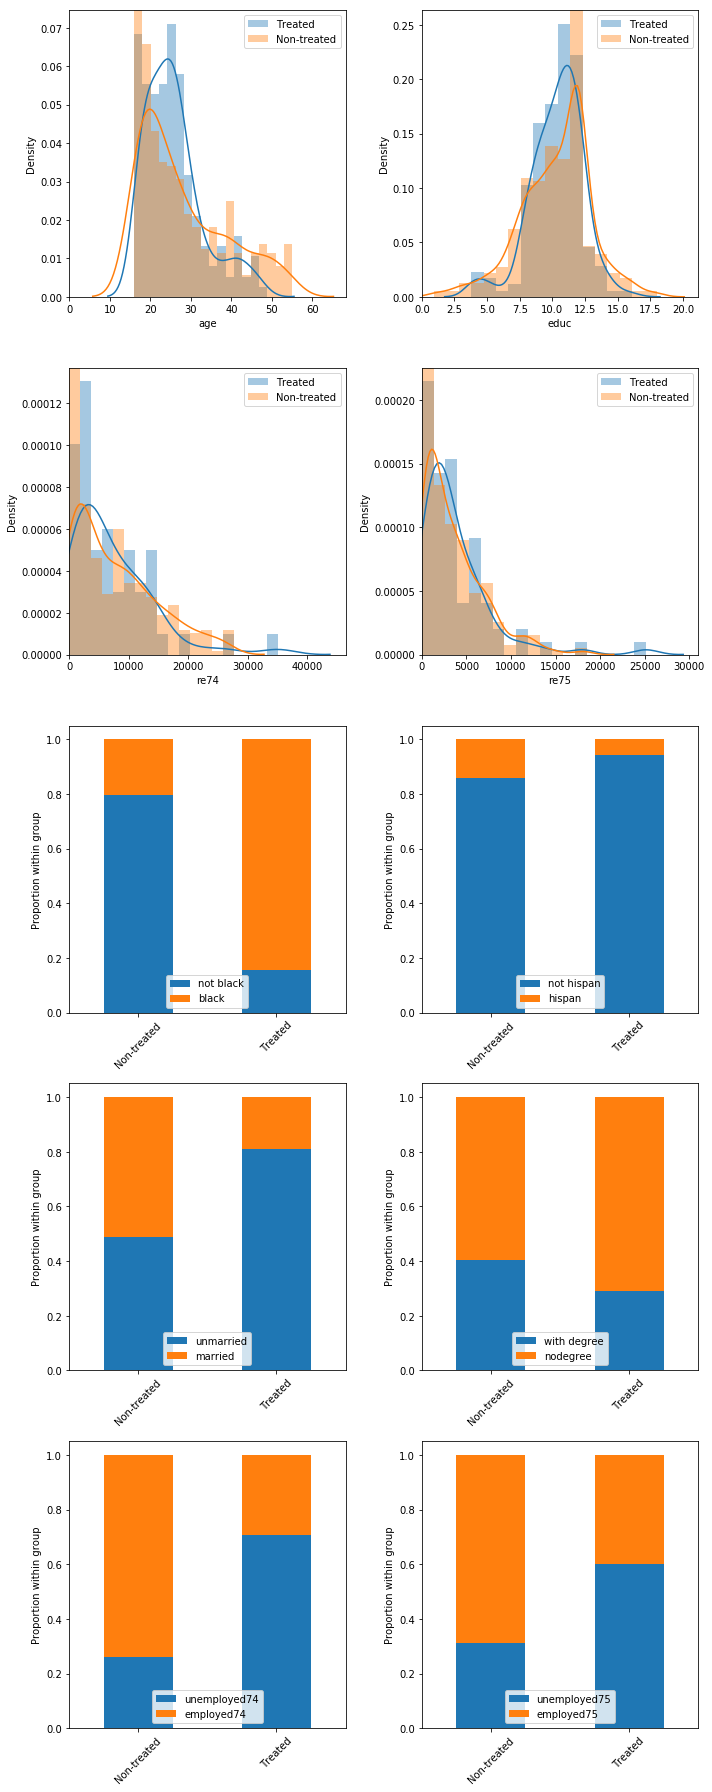

In [8]:
plot_features(dataset)

**Observations.** The most noticeable differences are in the following features:
- **employed74, employed75**: the treated set had a higher portion of unemployed individuals during 1974 and 1975.
- **black**: ~80% of the individuals in the treated set are black, as opposed to ~20% in the non-treated set.
- **married**: ~20% of the individuals in the treated set are married, as opposed to ~50% in the non-treated set.

**Conclusion.**

Just by looking at the distributions of the features we notice great differences, which indicate that the assignment of the individuals to the treatment most likely was not random. The next task will help us quantify to what extent it is possible to predict whether an individual was been assigned to the treatment or not.

#### 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)

## Answer
We use *logistic regression* so as to assign to each individual a propensity score, which indicates the probability of being assigned to the treatment (that is, a value between 0 and 1).

In [9]:
# By specifying C=10^9, we are basically disabling L2 regularization (which cannot be turned off directly in sklearn)
# We are not building a prediction model, so we do not care whether the model overfits
logistic = linear_model.LogisticRegression(C=1e9)
X = dataset[['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']]
y = dataset['treat']
logistic.fit(X, y)
dataset['propensity'] = logistic.predict_proba(X)[:, 1]

print("Accuracy of predictions:", logistic.score(X, y))

Accuracy of predictions: 0.806188925081


In [10]:
print("This random subset shows that we could correctly predict whether these 5 individuals were assigned to the \ntreatment.")
sample = dataset.sample(n=5, random_state=5)[["treat", "propensity"]]
sample.head()

This random subset shows that we could correctly predict whether these 5 individuals were assigned to the 
treatment.


,treat,propensity
504,0,0.046422
52,1,0.685513
406,0,0.020749
561,0,0.140767
424,0,0.134106


**Observations:**

As expected, this step shows that with a simple linear model we could predict with 81% accuracy whether an individual was assigned to the treatment. Therefore, we have to balance the two sets before being able to draw credible conclusions.

For the sake of completeness, we now show what would have happened if the subjects were assigned to random groups.

In [11]:
np.random.seed(1000)
y_random = np.random.randint(2, size=len(dataset)) # Assign random vector
logistic.fit(X, y_random)
print("Accuracy of predictions:", logistic.score(X, y_random))

Accuracy of predictions: 0.517915309446


As you can see, the accuracy is close to 50%, i.e. random. In reality, the classifier shows an accuracy slightly higher than 50% because it tends to overfit, but that is expected and does not represent a problem in our scenario.

#### 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

### Answer
We use the *networkx* library to match the subject in the two groups. The procedure is as follows:
- We build a bipartite graph, where the first set corresponds to the treated group, and the second set corresponds to the non-treated group.
- We connect the nodes of the treated set to the nodes of the non-treated set. The edge weight corresponds to the absolute difference of their propensity scores.
- We find the maximum-cardinality bipartite matching that also has the lowest total weight.
- Finally, we keep only the matched subjects.

**Important implementation detail:** networkx supports only max-weight matching, but we need min-weight matching. Fortunately, this optimization problem can be easily transformed by changing the sign of edge weights, because $\min(f(x)) = -\max(-f(x))$.

In [12]:
def min_weight_matching(dataset, max_weight=1):
    """ Build a bipartite graph in which the nodes are the individuals. Individuals belonging two different sets
    (treated and non-treated set) are connected by weighted edges. The weight is the absolute value of the 
    difference of the propensity scores of the two individuals. Only the edges whose weight 
    is under max_weight are kept. 
    Returns the datatset after dropping all the non-matched entries.
    """
    
    treated = dataset[dataset['treat'] == 1].index
    nontreated = dataset[dataset['treat'] == 0].index

    # Build bipartite graph
    G = nx.Graph()

    for i in dataset.index:
        G.add_node(i)

    for i in treated:
        for j in nontreated:
            weight = abs(dataset['propensity'].loc[i] - dataset['propensity'].loc[j])
            if weight < max_weight:
                G.add_edge(i, j, weight=-weight) # Note the negative weight

    # Find the optimal matching that also has maximum cardinality (i.e. number of matched nodes)
    matching = nx.algorithms.max_weight_matching(G, maxcardinality=True)
    
    # Build the dataframe to show the distances of the matched points
    matches = pd.DataFrame()
    matches["id_1"] = matching.keys()
    matches["id_2"] = matching.values()
    prop1 = pd.Series(dataset.loc[matches["id_1"]].propensity.tolist())
    prop2 = pd.Series(dataset.loc[matches["id_2"]].propensity.tolist())
    matches["edge weight"] = (prop1 - prop2).abs().round(decimals=4)
    matches = matches.sort_values(by="edge weight")
    matches = matches[matches['id_1'] > matches['id_2']]

    print('Found optimal matching with total weight', matches["edge weight"].sum())
    print('Number of matches:', matches.shape[0])
    
    print("These are the 5 best matches:")
    display(matches.head())
    print("These are the 5 worse matches:")
    display(matches.tail())
    
    matches["edge weight"].reset_index()["edge weight"].hist(bins=50)
    plt.title("Distribution of the matches")
    plt.ylabel("Number of matches")
    plt.xlabel("Weight of the edge")

    dataset_balanced = dataset.loc[matching.keys()]
    return dataset_balanced

Found optimal matching with total weight 36.9748
Number of matches: 185
These are the 5 best matches:


,id_1,id_2,edge weight
0,595,24,0.0
23,383,124,0.0
27,259,123,0.0
18,558,103,0.0
16,560,46,0.0


These are the 5 worse matches:


,id_1,id_2,edge weight
313,308,49,0.6027
352,421,80,0.6086
331,613,93,0.6089
358,268,76,0.6131
356,393,33,0.6148


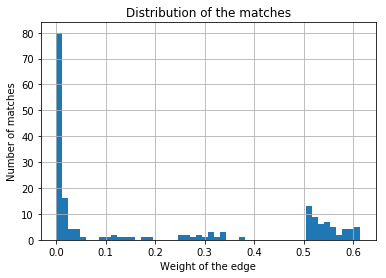

In [13]:
dataset_balanced = min_weight_matching(dataset)

As can be seen, each subject of of the smallest group (treated) has been matched to exactly one subject of the non-treated group, for a total of 185+185 = 370 subjects.

We now repeated the analysis of the outcome and of the features.

,Treated,Non-treated
count,185,185


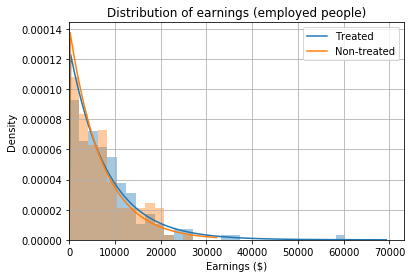

,Earnings (treated),Earnings (non-treated)
count,140,138
mean,8389,7125
std,8042,5940
min,289,31
25%,3167,2245
50%,6504,6091
75%,11017,10072
max,60307,25564


In [14]:
analyse_earnings_distribution(dataset_balanced)

By looking at the outcome distribution, our conclusion remains the same. There are no noticeable differences between the two groups.

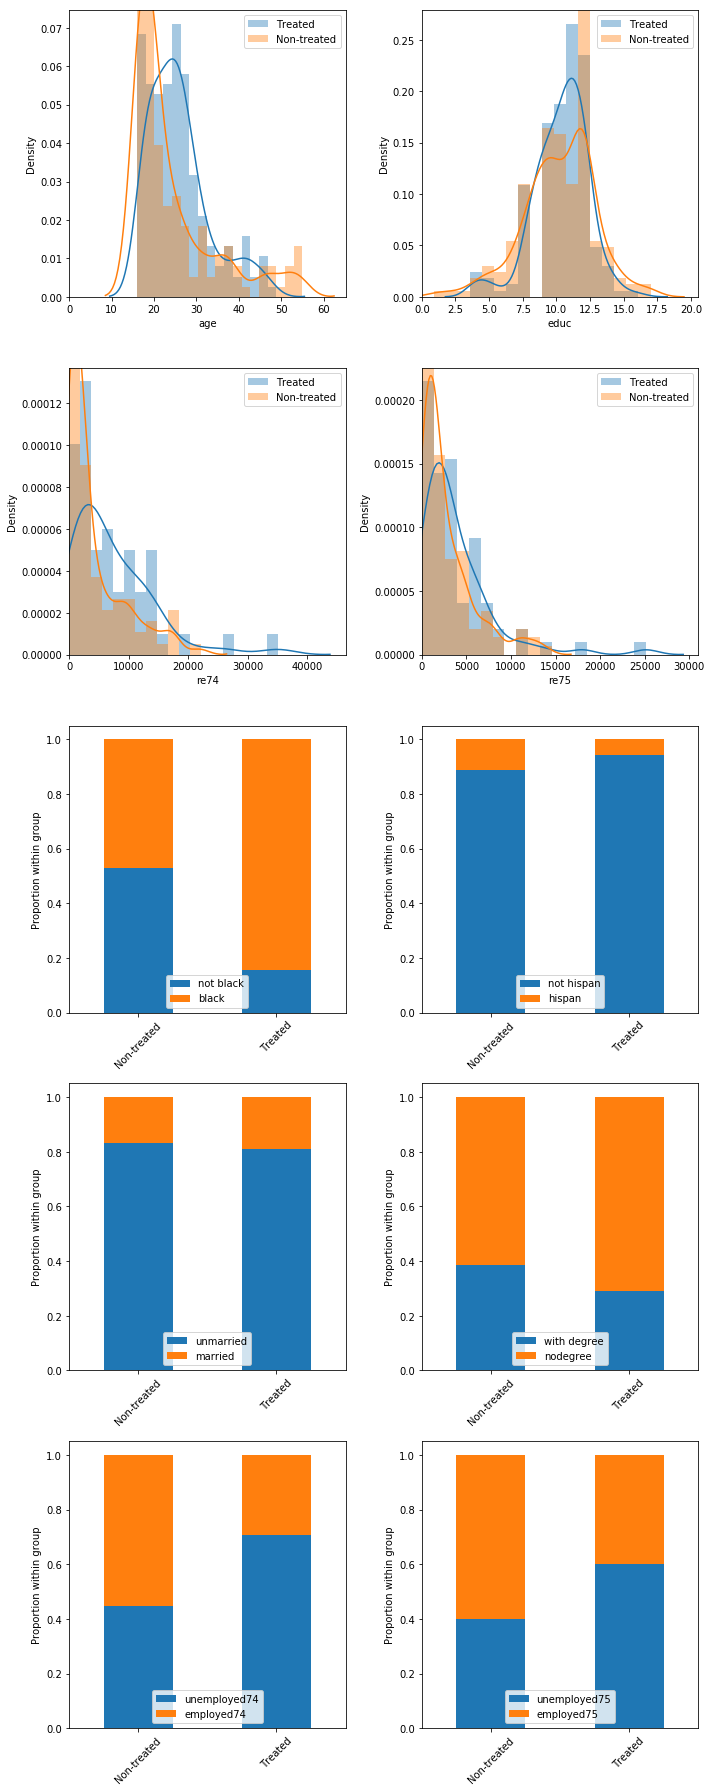

In [15]:
plot_features(dataset_balanced)

**Observations**

We can notice that the features are more equally distributed among the two sets, in particular **employed74** and **employed75** show less discrepancy in the number of individuals with 0 earnings than before. However, we are still not satisfied enough, since there are still datapoints which have been matched but do not have a very similar propensity score. This is due to the fact that the algorithm matches all the 185 entries in the treated set with 185 entries in in the other set, even if they have not a similar score. For example, we can notice that the distributions of the **black people** (and, to a smaller extent, age) are still unbalanced. We take care of this problem in the next task.

#### 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.

### Answer
Since the **'black'** feature is still not balanced among the two sets, we decided to repeat the matching algorithm in a more constrained way. This time, we create an edge between two individuals only if their `black` feature is exactly the same (that is, if they are both black or both non-black).

In [16]:
treated = dataset[dataset['treat'] == 1].index
nontreated = dataset[dataset['treat'] == 0].index

G = nx.Graph()

for i in dataset.index:
    G.add_node(i)

for i in treated:
    for j in nontreated:
        if dataset['black'].loc[i] == dataset['black'].loc[j]:
            G.add_edge(i, j, weight=-abs(dataset['propensity'].loc[i] - dataset['propensity'].loc[j]))

matching = nx.algorithms.max_weight_matching(G, maxcardinality=True)

weight = 0
for a, b in matching.items():
    weight += G[a][b]['weight']
print('Found optimal matching with total difference', -weight/2)
dataset_balanced = dataset.loc[matching.keys()]
print('Number of matches:', len(dataset_balanced)/2)

Found optimal matching with total difference 0.736358796708
Number of matches: 116.0


Of course, this means that we get a slightly lower population size (116+116 = 232 individuals), since we are allowing only certain matches.

Again, we repeat the feature analysis.

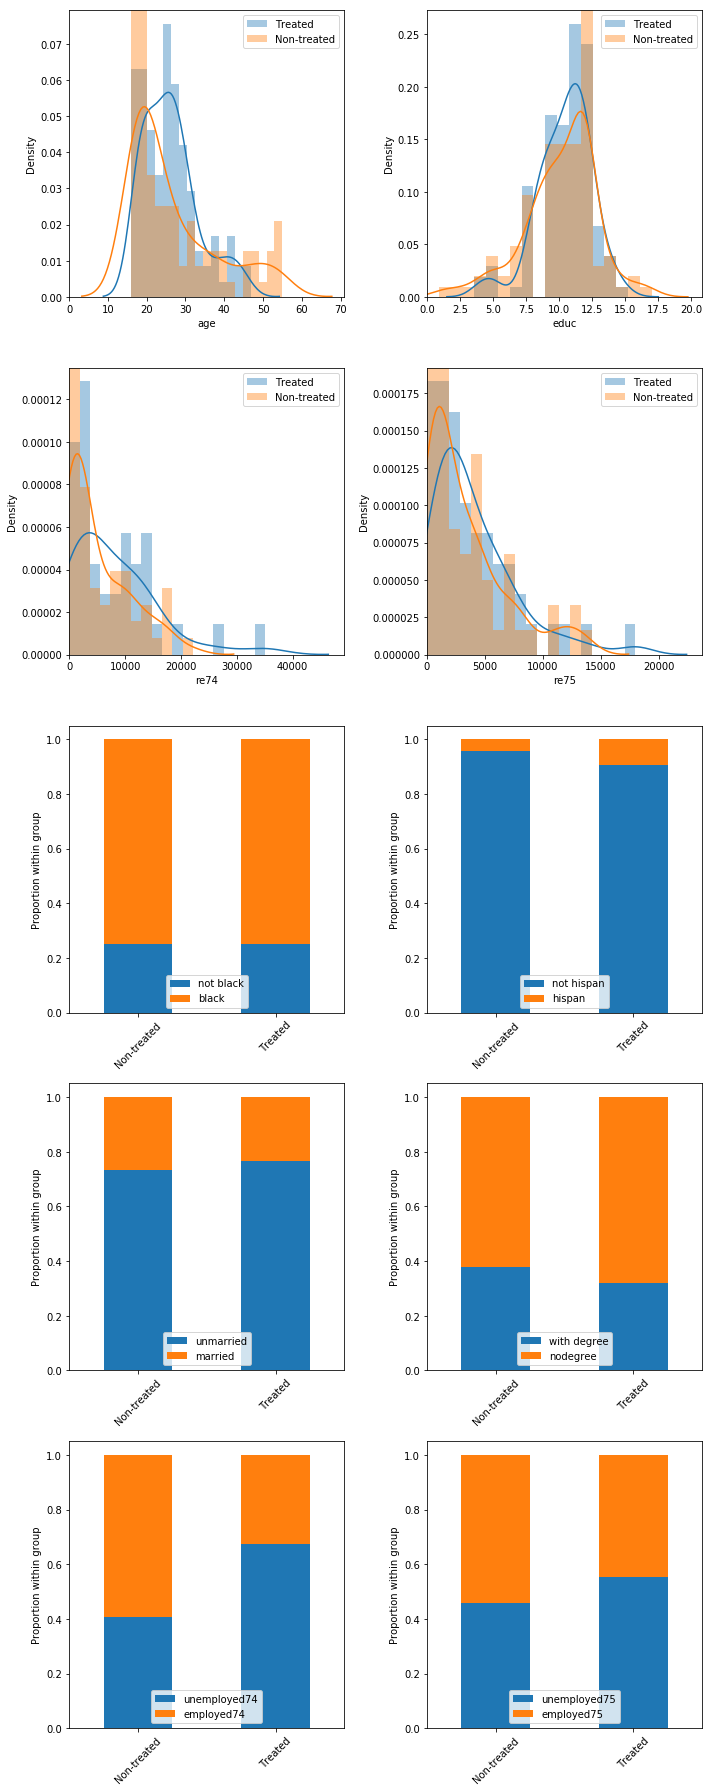

In [17]:
plot_features(dataset_balanced)

As can be seen, the two groups are now matched almost perfectly. To reinforce our argument, we train again our logistic regression model and we evaluate the accuracy.

In [18]:
logistic = linear_model.LogisticRegression(C=1e9)
X = dataset_balanced[['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']]
y = dataset_balanced['treat']
logistic.fit(X, y)

print("Accuracy of predictions:", logistic.score(X, y))

Accuracy of predictions: 0.594827586207


This (59%) is much better than the previous result (81%). In fact, it is closer to random.

#### 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

### Answer

,Treated,Non-treated
count,116,116


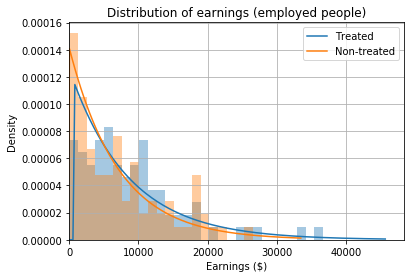

,Earnings (treated),Earnings (non-treated)
count,86,83
mean,9044,7127
std,7296,6348
min,559,31
25%,3904,1933
50%,7468,6083
75%,12360,10573
max,36646,25564


In [19]:
analyse_earnings_distribution(dataset_balanced)

## Conclusion
Our last analysis reveals a mean increase in earnings of about 1900 dollars (median 1385), which contradicts the previous results. This seems in line with Dehejia & Wahba's research "[Causal Effects in Nonexperimental Studies: Reevaluating the Evaluation of Training Programs](http://users.nber.org/~rdehejia/papers/dehejia_wahba_jasa.pdf)", which reports a figure of 1700$.

However, whether the job training program was effective is still a matter of debate. The employment rates do not seem to differ, and it should be assessed whether the difference in salary is statistically significant, given that we have a small sample. Our personal research on the topic presented us with contrasting opinions.

### Trial 2: keep only the edges whose weight is under a threshold**
For curiosity, we want to see what happens if we match only subjects that have a similar propensity score (by applying a limit), without manually matching individual features. We set the maximum difference to 0.05.

Found optimal matching with total weight 0.4259
Number of matches: 114
These are the 5 best matches:


,id_1,id_2,edge weight
0,595,24,0.0
23,383,124,0.0
25,222,166,0.0
18,558,103,0.0
29,452,89,0.0


These are the 5 worse matches:


,id_1,id_2,edge weight
217,189,25,0.0287
221,540,36,0.0322
223,211,162,0.0337
219,253,45,0.0360
201,190,32,0.0455


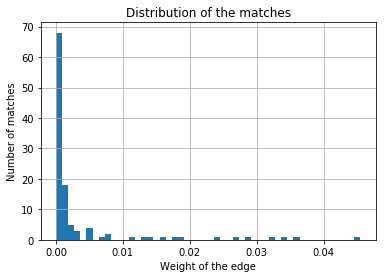

In [20]:
dataset_balanced = min_weight_matching(dataset, max_weight=0.05)

We get a lower total weight, meaning that the matched datapoints are closer than before.

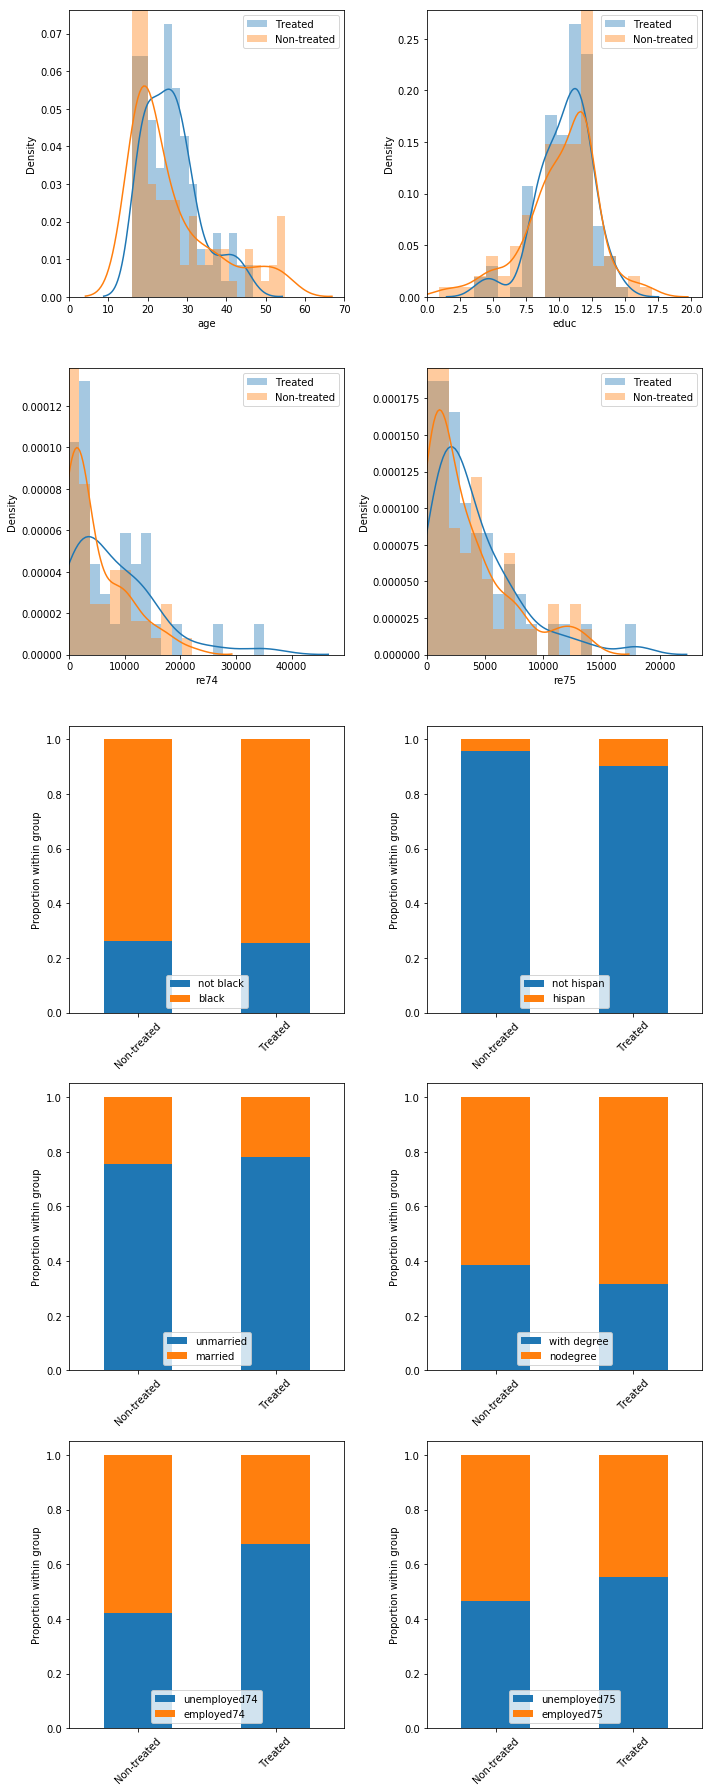

In [21]:
plot_features(dataset_balanced)

This matching is similar to the one produced earlier. The features are well-balanced, except (maybe) for the unemployed indicator in 1974.

,Treated,Non-treated
count,114,114


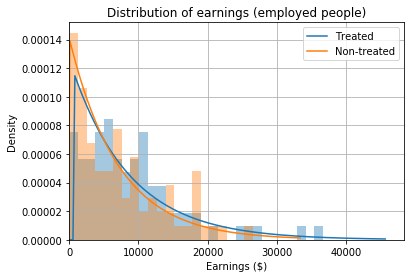

,Earnings (treated),Earnings (non-treated)
count,84,82
mean,9019,7149
std,7259,6264
min,559,31
25%,3949,2142
50%,7468,6091
75%,12245,10798
max,36646,25564


In [22]:
analyse_earnings_distribution(dataset_balanced)

Our conclusions are the same as before. The result seems identical to the last step of the exercise.

## Question 2: Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

1. Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

### Answer

In [23]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import itertools
import multiprocessing

We load the *20newsgroup* dataset using the built-in function by sklearn. Since we will split the dataset manually, we download everything.

In [24]:
newsgroups_loaded = fetch_20newsgroups(subset='all')
newsgroups_loaded['target_names']

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

The dataset consists of newsgroup posts divided by categories. In this dataset, 20 categories (shown above) are available. For each post in ```newsgroups['data'][i]```, we have the corresponding ground truth in ```newsgroups['target'][i]```, represented as an index between 0 and 19. The full name of the category can be retrieved simply by looking at ```newsgroups['target_name'][i]```.

We now split the dataset into three groups:
- **Training set (80%):** it will be used for training the model.
- **Validation set (10%):** it will be used for experimenting with the model and tuning its hyperparameters, so as to obtain the best accuracy. The model will never be trained using this set.
- **Test set (10%):** it will be evaluated only once, when the model is ready. This will determine the final accuracy of our model.

This scheme allows us to evaluate whether the model generalizes or overfits the dataset. Generally speaking, we want our model to generalize well (that is, be able to classify unseen samples correctly) instead of just memorizing the input. A better approach would be to use *k-fold cross-validation*, i.e. split the dataset into $k$ parts, train it $k$ times on $k - 1$ parts, and validate it on the remaining parts. This would yield a more accurate estimate of the prediction error. However, we employed a static validation set since it is explicitly asked to do so (additionally, k-fold is more computationally expensive).

Prior to splitting the dataset, we randomly shuffle the records. Throughout the rest of the homework, we will use a fixed seed (```random_state=0```) for all random operations, so as to ensure reproducibility of results.

In [25]:
newsgroups = pd.DataFrame()
newsgroups['data'] = newsgroups_loaded['data']
newsgroups['target'] = newsgroups_loaded['target']
shuffled = newsgroups.sample(frac=1, random_state=0)
shuffled.head()

,data,target
14736,From: jeremi@ee.ualberta.ca (William Jeremiah)...,2
15780,From: fioranvj@cnsvax.uwec.edu\nSubject: WANTE...,6
7127,From: maynard@ramsey.cs.laurentian.ca (Roger M...,10
2778,From: ree88132@zach.fit.edu (Keith Ledig)\nSub...,12
14477,From: dly@joule.elee.calpoly.edu (Dixon Ly)\nS...,2


In [26]:
n = shuffled.shape[0]
newsgroups_train = shuffled[:int(n*0.8)]
newsgroups_validation = shuffled[int(n*0.8):int(n*0.9)]
newsgroups_test = shuffled[int(n*0.9):]
print('# samples in the training set:', newsgroups_train.shape[0])
print('# samples in the validation set:', newsgroups_validation.shape[0])
print('# samples in the test set:', newsgroups_test.shape[0])

# samples in the training set: 15076
# samples in the validation set: 1885
# samples in the test set: 1885


We now proceed with converting each document to a feature vector. Machine learning algorithms require vector representations for their inputs, that is, each sample must be a point in $\mathbb{R}^d$ space. Text, on the other hand, is not well suited to be represented as a vector, and therefore some form of pre-processing is required. The idea is that documents that are similar in content/semantics are also close among each other in their vector space.

We perform the feature extraction using ```TfidfVectorizer```, which extracts *tf-idf* features. In a way that resembles a *bag-of-words* approach, words are assigned a weight that is proportional to the number of times they appear inside a document. Additionally, words that appear in many documents (e.g. "this", "it", "the", "is") are penalized.

The algorithm works by first tokenizing each document (using ```CountVectorizer```), that is, extracting the words and getting the count for each word. Afterwards, features are transformed with ```TfidfTransformer```, which produces the final *tf-idf* features. The result is a sparse matrix that can be fed to a classifier.

In [27]:
vectorizer = TfidfVectorizer()
X_tr = vectorizer.fit_transform(newsgroups_train['data'])
X_va = vectorizer.transform(newsgroups_validation['data'])
X_te = vectorizer.transform(newsgroups_test['data'])

y_tr = newsgroups_train['target'].values
y_va = newsgroups_validation['target'].values
y_te = newsgroups_test['target'].values

Note that we fitted the vectorizer only on the training set, *after* splitting the dataset. The validation and test sets are transformed using the same model, as if they were unseen samples. This is the correct approach, since the full pipeline (vectorizer + classifier) must be trained using the training set alone. In a realistic scenario, the validation/test sets should only be used for evaluating the model. Fitting the vectorizer on the latter would bias the final result.

In [28]:
X_tr.shape

(15076, 155842)

We can also see that our dataset consists of 155842 features (a very sparse feature vector!)
Each feature corresponds to a word, meaning that our dictionary contains 155842 words.
Normally, we would limit the feature vector size to a small number (e.g. 100 to 1000 features) by selecting the words with the highest frequency. However, since we plan to use random forests, they are already able to do the splitting efficiently and do not require additional pre-processing.

**2.** Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.

### Answer
We decided to keep the number of estimators constant, and run the grid search only on the maximum depth. As a rule of thumb, the number of estimators in a random forest should be set to a high value (e.g. 100 to 1000) and be no longer touched, since it can only improve the result. As described by the original authors of the algorithm, ["you can run as many trees as you want"](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#remarks). Many researchers claim that 100 to 300 estimators (i.e. trees) are more than enough for almost all cases. As a result, the choice of this hyperparameter is just a trade-off between training time and accuracy, given that after a certain threshold the accuracy no longer improves.

Another advantage of having a large number of trees is that the result is more stable. Random forest use *bagging*, which means that the final result is the average of the outcomes of many simple models. If a low number of trees is used, the result will tend to fluctuate due to the high variance (and this could even compromise the validation result), whereas with many trees the result will be more consistent. This can be observed by running a k-fold cross validation (which is not done here): the higher the number of trees is, the lower the standard deviation of the error/accuracy will be.

We set the number of estimators to 300, which requires a lot of training time, but produces a very stable estimate.

In [29]:
num_estimators = 300
num_threads = multiprocessing.cpu_count()
print('Random forests will be trained using', num_threads, 'CPU cores and', num_estimators, 'estimators')

Random forests will be trained using 4 CPU cores and 300 estimators


The optimal tree depth will be searched between 5 and 100 (in steps of 5). This range is somewhat arbitrary, but it is important to keep in mind that the computational cost will increase along with the tree depth, and going over 100 requires a lot of training time. For each step, we train the model on the training set and evaluate the accuracy on the validation set. The aim, of course, is to maximize the accuracy.

In [30]:
depths = np.arange(5, 105, 5)
tr_accuracies = []
va_accuracies = []
for depth in depths:
    clf = RandomForestClassifier(max_depth=depth, random_state=0, n_estimators=num_estimators, n_jobs=num_threads)
    clf.fit(X_tr, y_tr)
    tr_accuracies.append(clf.score(X_tr, y_tr))
    va_accuracies.append(clf.score(X_va, y_va))
    print('Depth:', depth, tr_accuracies[-1], va_accuracies[-1])

Depth: 5 0.717232687716 0.705570291777
Depth: 10 0.803860440435 0.758620689655
Depth: 15 0.85971079862 0.779840848806
Depth: 20 0.908463783497 0.794694960212
Depth: 25 0.934664367206 0.804774535809
Depth: 30 0.953701247015 0.812732095491
Depth: 35 0.968360307774 0.82599469496
Depth: 40 0.977845582383 0.830769230769
Depth: 45 0.984279649774 0.835013262599
Depth: 50 0.988657468825 0.835543766578
Depth: 55 0.991310692491 0.844562334218
Depth: 60 0.994494560891 0.840318302387
Depth: 65 0.996285486867 0.850397877984
Depth: 70 0.997015123375 0.853050397878
Depth: 75 0.997943751658 0.852519893899
Depth: 80 0.998474396392 0.850928381963
Depth: 85 0.998938710533 0.847214854111
Depth: 90 0.9992040329 0.856233421751
Depth: 95 0.999469355267 0.856233421751
Depth: 100 0.999734677633 0.859416445623


We also plot the comparison between training error and validation error, according to the tree depth. While the validation accuracy is always lower than the training accuracy (which is normal), the trend reveals that a higher tree depth tends to improve the result (at least, in our scenario).

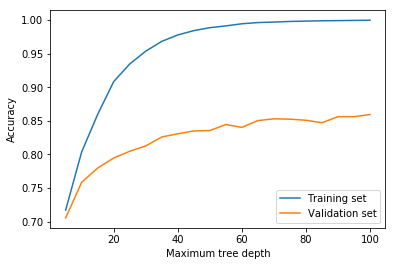

In [31]:
plt.plot(depths[:len(tr_accuracies)], tr_accuracies)
plt.plot(depths[:len(va_accuracies)], va_accuracies)
plt.legend(['Training set', 'Validation set'])
plt.ylabel('Accuracy')
_ = plt.xlabel('Maximum tree depth')

Finally, we evaluate the final model on the test set.

In [32]:
best_depth = depths[np.argmax(va_accuracies)]
print('The best tree depth is', best_depth)
clf = RandomForestClassifier(max_depth=best_depth, random_state=0, n_estimators=num_estimators, n_jobs=num_threads)
clf.fit(X_tr, y_tr)
print('Test accuracy:', clf.score(X_te, y_te))

The best tree depth is 100
Test accuracy: 0.84774535809


It can be observed that the training error is higher than the validation/test error. This is normal, as the model tends to slightly overfit the training set. The important outcome is that the random forest generalizes well to unseen data, which seems the case.

We now plot the so-called *confusion matrix*, which allows us to analyze the behaviour of the model.

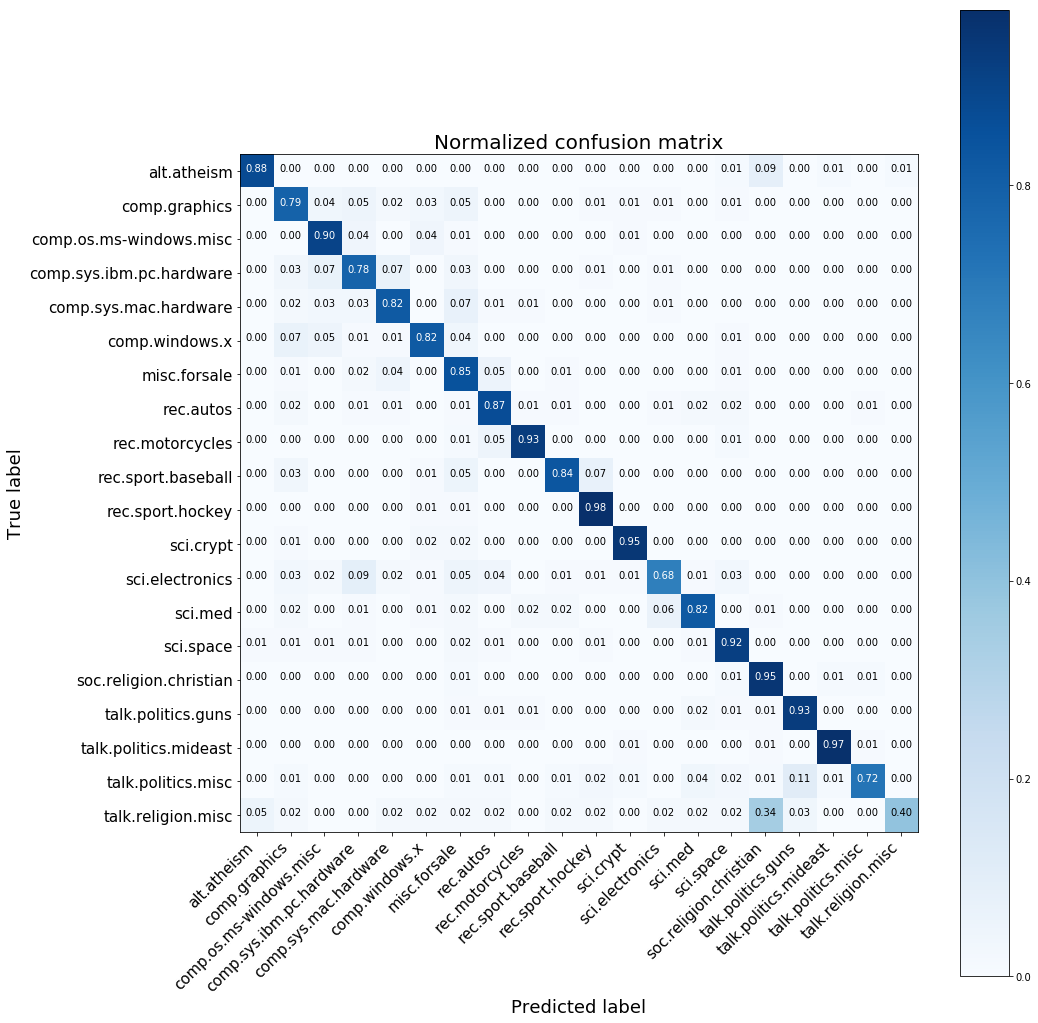

In [33]:
def plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues):
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Normalized confusion matrix', fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)
    plt.tick_params(labelsize=15)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j],  '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_te, clf.predict(X_te))

# Plot confusion matrix
plot_confusion_matrix(conf_matrix, classes=newsgroups_loaded['target_names'])

As can be seen from the figure, the model seems to predict relatively well. Most errors are related to religion categories, which are closely related among each other.

Another common practice in machine learning consists in interpreting the model, that is, visualizing the features that are learned, and how they affect each prediction label. In order to do this, we analyze the field `feature_importances_`, which, as the name suggests, provides us with the importance of each feature (a real value between 0 and 1 that represents the impact on the final prediction). In our case, each feature corresponds to a word, as returned by ```TfidfVectorizer```. Similarly, we can convert a feature back to a textual word by using the inverse map.
We now show the 10 most important features of the final model.

In [34]:
important_features = pd.DataFrame(clf.feature_importances_).sort_values(by=0, ascending=False).head(10)

mapping = vectorizer.get_feature_names()
important_features.index = important_features.index.map(lambda x: mapping[x])
important_features

,0
sale,0.004865
windows,0.004588
dod,0.004233
car,0.004003
bike,0.003934
clipper,0.003472
space,0.003381
re,0.003082
of,0.002892
encryption,0.002880


This is not very suggestive. We can see the words that have the highest impact on the model, but we cannot really interpret how they affect the result, as the model predicts 20 classes. We need to convert our interpretation problem to a binary classification problem. The solution is to build a [one-vs-rest](https://en.wikipedia.org/wiki/Multiclass_classification#One-vs.-rest) model, that is, for each label $k$ we train a model where $y_i=1$ if $y_i==k$ and $0$ otherwise. This way, we can get useful feature importances for each category of posts.

In [35]:
series = []
for i, name in enumerate(newsgroups_loaded['target_names']):
    clf = RandomForestClassifier(max_depth=best_depth, random_state=0, n_estimators=num_estimators, n_jobs=num_threads)
    clf.fit(X_tr, y_tr == i)
    important_features = pd.DataFrame(clf.feature_importances_).sort_values(by=0, ascending=False).head(10)
    important_features.index = important_features.index.map(lambda x: mapping[x])
    important_features.index.name = name
    series.append(important_features.reset_index()[name])

We now show the top 10 words for each category. We choose not to display the raw value of the importance, as they are not really easy to interpet. In simple words, if these words appear in a newsgroup post, they will tend to shift the attention of the classifier towards the respective class.

In [36]:
result = pd.concat(series, axis=1)
result.index = range(1, 11)
result.index.name = 'rank'
result

,alt.atheism,comp.graphics,comp.os.ms-windows.misc,comp.sys.ibm.pc.hardware,comp.sys.mac.hardware,comp.windows.x,misc.forsale,rec.autos,rec.motorcycles,rec.sport.baseball,rec.sport.hockey,sci.crypt,sci.electronics,sci.med,sci.space,soc.religion.christian,talk.politics.guns,talk.politics.mideast,talk.politics.misc,talk.religion.misc
rank,,,,,,,,,,,,,,,,,,,,
1,atheists,graphics,windows,controller,mac,motif,sale,car,bike,baseball,hockey,encryption,circuit,doctor,space,athos,gun,israeli,cramer,weiss
2,solntze,3d,microsoft,bios,quadra,x11r5,shipping,cars,dod,pitcher,nhl,clipper,electronics,geb,orbit,rutgers,ranch,israel,gay,royalroads
3,atheism,images,win3,ide,centris,window,offer,engine,bikes,pitching,playoffs,chip,circuits,banks,shuttle,christians,firearms,arab,clayton,psyrobtw
4,rushdie,image,dos,bus,apple,lcs,forsale,toyota,ride,sox,team,nsa,voltage,disease,prb,clh,atf,arabs,optilink,ceccarelli
5,livesey,tiff,cica,card,powerbook,widget,the,automotive,motorcycle,braves,leafs,crypto,shack,shameful,moon,god,fbi,armenian,kaldis,sandvik
6,islamic,gif,ini,isa,iisi,xpert,condition,v6,riding,mets,game,escrow,resistor,medical,launch,christ,waco,turkish,pyramid,9615
7,keith,pov,file,drive,lc,expo,re,ford,bmw,jays,devils,key,rf,msg,nasa,jesus,weapons,armenia,percentage,kent
8,bil,animation,supporters,scsi,lciii,xterm,for,autos,motorcycles,batting,pens,tapped,amp,dsl,spacecraft,church,guns,turks,homosexuals,newton
9,osrhe,format,challenge,pc,duo,server,asking,nissan,rider,pitchers,playoff,sternlight,copy,medicine,zoo,bible,burns,jews,horne,kendig


The features certainly make sense. For instance, we can observe that categories related to religion contain words commonly associated with religion. Likewise, categories related to hardware/software contain domain-specific words.